In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
fromage = pd.read_csv("http://www.math.u-bordeaux.fr/~mchave100p/wordpress/wp-content/uploads/2013/10/fromage.txt",sep="\t",header=0,index_col=0)

URLError: <urlopen error [Errno 110] Connection timed out>

In [ ]:
fromage


In [ ]:
# on centre et on réduit

import sklearn
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
fromage_cr = sc.fit_transform(fromage.values)

In [ ]:
#dimension des données

print(fromage.shape)

#statistiques descriptives

print(fromage.describe())




In [ ]:
#graphique - croisement deux à deux des variables

scatt_mat = scatter_matrix(fromage,figsize=(9,9))[-1]

## CAH

In [ ]:
#librairies pour la CAH

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

#générer la matrice des liens

Z = linkage(fromage_cr,method='ward',metric='euclidean')

#affichage du dendrogramme

plt.title("CAH")
dendrogram(Z,labels=fromage.index,orientation='right',color_threshold=0)
plt.show()

In [ ]:
#matérialisation des 4 classes (hauteur t = 7)

plt.title('CAH avec matérialisation des 4 classes')
dendrogram(Z,labels=fromage.index,orientation='right',color_threshold=7)
plt.show()



In [ ]:
#découpage à la hauteur t = 7 ==> identifiants de 4 groupes obtenus

groupes_cah = fcluster(Z,t=7,criterion='distance')
print(groupes_cah)


In [ ]:
#index triés des groupes

idg = np.argsort(groupes_cah)

#affichage des observations et leurs groupes

print(pd.DataFrame(fromage.index[idg],groupes_cah[idg]))


Le 1er groupe est constitué de fromages frais.  
Le 2nd de fromages à pâte molle.  
Le 3ème de fromages durs.  
Le 4ème est un peu fourre-tout.  


## K-means

In [ ]:
#k-means sur les données centrées et réduites

from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=4)  # on choisit 4 avec l'étude du dessus
kmeans.fit(fromage_cr)

#index triés des groupes

print(kmeans.labels_)
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes

print(pd.DataFrame(fromage.index[idk],kmeans.labels_[idk]))



In [ ]:
#distances aux centres de classes des observations

dist_data = pd.DataFrame(kmeans.transform(fromage_cr),index = fromage.index)
print(dist_data)

In [12]:
#correspondance avec les groupes de la CAH

pd.crosstab(groupes_cah,kmeans.labels_)

col_0  0  1  2   3
row_0             
1      0  0  4   0
2      0  4  0   0
3      4  0  0   0
4      1  2  0  14

Il y bien correspondances entre les groupes proposés par la CAH et la méthode des K-means.
Les deux groupes 1 sont identiques, et il y a de fortes correspondances dans les autres.

[0.48626255 0.36025261 0.33464766 0.31602974 0.30639458 0.29895244
 0.29706331 0.2292655  0.26464697 0.23810399 0.21789609 0.19708792
 0.20921078 0.19794021 0.171882  ]


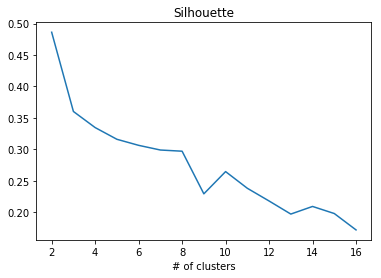

In [13]:
#librairie pour évaluation des partitions
from sklearn import metrics

#utilisation de la métrique "silhouette"
#faire varier le nombre de clusters de 2 à 10
res = np.arange(15,dtype="double")
for k in np.arange(15):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(fromage_cr)
    res[k] = metrics.silhouette_score(fromage_cr,km.labels_)
print(res)

#graphique
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,17,1),res)
plt.show()

le nombre de groupes le plus adapté au sens de la metric "silhouette" est 2.

[20.70252871 20.30949593 21.46005127 19.55986152 18.65410496 16.80993748
 15.49660468 15.41220583 15.19117737 15.16033006 15.7631012  15.84946971
 17.31910547 17.26485636 16.97864621]


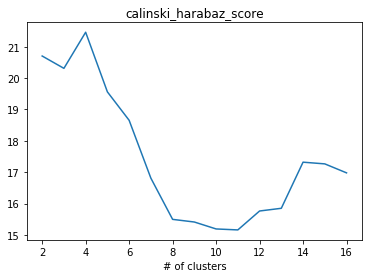

In [14]:
#utilisation de la métrique "calinski_harabaz_score"
#faire varier le nombre de clusters de 2 à 10
res = np.arange(15,dtype="double")
for k in np.arange(15):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(fromage_cr)
    res[k] = metrics.calinski_harabaz_score(fromage_cr,km.labels_)
print(res)

#graphique
import matplotlib.pyplot as plt
plt.title("calinski_harabaz_score")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,17,1),res)
plt.show()

le nombre de groupe le plus adapté au sens de la metric "calinski_harabaz_score" est 4.

D'autres metrics....  ('https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics')

## interprétation des classes


In [15]:
#moyenne par variable

m = fromage.mean()

#TSS

TSS = fromage.shape[0]*fromage.var(ddof=0)
print(TSS)


calories       236550.965517
sodium         330711.034483
calcium        147292.285517
lipides          1850.550345
retinol         16347.948276
folates          3848.226897
proteines        1356.282069
cholesterol     22339.034483
magnesium        3586.965517
dtype: float64


In [16]:
#data.frame conditionnellement aux groupes

gb = fromage.groupby(kmeans.labels_)

#effectifs conditionnels

nk = gb.size()
print(nk)


0     5
1     6
2     4
3    14
dtype: int64


In [17]:
#moyennes conditionnelles

mk = gb.mean()
print(mk)

#pour chaque groupe écart à la moyenne par variable

EMk = (mk-m)**2

#pondéré par les effectifs du groupe

EM = EMk.multiply(nk,axis=0)


     calories      sodium  calcium    lipides    retinol    folates  \
0  377.200000  130.400000   278.98  29.460000  64.560000   3.120000   
1  288.000000  252.916667   110.10  23.866667  95.866667  31.266667   
2  101.750000   44.750000   133.75   6.275000  55.150000  16.475000   
3  334.285714  267.428571   199.70  27.500000  60.050000   7.728571   

   proteines  cholesterol  magnesium  
0  29.120000   102.000000  45.400000  
1  18.883333    68.333333  21.666667  
2   7.200000    18.250000  11.250000  
3  21.228571    83.571429  27.142857  


In [18]:
#somme des valeurs => BSS

BSS = np.sum(EM,axis=0)
print(BSS)


calories       204332.558374
sodium         198134.447578
calcium         91337.127517
lipides          1576.637511
retinol          6258.237943
folates          2927.429492
proteines        1099.017164
cholesterol     17817.522578
magnesium        2855.967898
dtype: float64


In [19]:
#carré du rapport de corrélation
#variance expliquée par l'appartenance aux groupes pour chaque variable

R2 = BSS/TSS
print(R2)

calories       0.863799
sodium         0.599117
calcium        0.620108
lipides        0.851983
retinol        0.382815
folates        0.760722
proteines      0.810316
cholesterol    0.797596
magnesium      0.796207
dtype: float64


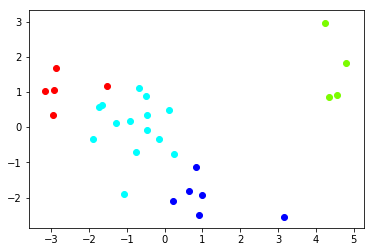

In [20]:
#ACP

from sklearn.decomposition import PCA
acp = PCA(n_components=2).fit_transform(fromage_cr)

#projeter dans le plan factoriel avec un code couleur différent selon le groupe

for couleur,k in zip(['red','blue','lawngreen','aqua'],[0,1,2,3]):
    plt.scatter(acp[kmeans.labels_==k,0],acp[kmeans.labels_==k,1],c=couleur)
plt.show()

#### problème:
le groupe 1 ici en bleu, écrase les autres données en la tassant dans une partie du graphe.  
Il convient donc d'exclure ces données et de recommencer l'ACP dans un autre plan que ce plan factoriel.

In [21]:
#retirer des observations le groupe n°1 du k-means précédent
fromage_subset = fromage.iloc[kmeans.labels_!=1,:]

print(fromage_subset.shape)
print(fromage_subset)

(23, 9)
                    calories  sodium  calcium  lipides  retinol  folates  \
Fromages                                                                   
Babybel                  314   238.0    209.8     25.1     63.7      6.4   
Beaufort                 401   112.0    259.4     33.3     54.9      1.2   
Bleu                     342   336.0    211.1     28.9     37.1     27.5   
Cantal                   367   256.0    264.0     28.8     48.8      5.7   
Cheddar                  406   172.0    182.3     32.5     76.4      4.9   
Comte                    399    92.0    220.5     32.4     55.9      1.3   
Edam                     327   148.0    272.2     24.7     65.7      5.5   
Emmental                 378    60.0    308.2     29.4     56.3      2.4   
Fr.fondu.45              292   390.0    168.5     24.0     77.4      5.5   
Fr.frais20nat.            80    41.0    146.3      3.5     50.0     20.0   
Fr.frais40nat.           115    25.0     94.8      7.8     64.3     22.6   
Maro

In [22]:
#centrer et réduire
fromage_subset_cr = sc.fit_transform(fromage_subset.values)
print(fromage_subset_cr)

[[ 0.10971902  0.34860435  0.07006951  0.0985036   0.27413671 -0.25916561
   0.28379743 -0.20401983 -0.11713552]
 [ 0.99143689 -0.77515028  0.87182776  1.03206036 -0.41086663 -0.98848814
   0.82548546  1.43669908  1.0995625 ]
 [ 0.39349029  1.22263573  0.09108334  0.53112747 -1.79644157  2.7002008
  -0.04121539  0.45226773 -0.11713552]
 [ 0.64685749  0.50914073  0.94618437  0.51974263 -0.88569849 -0.35734365
   0.33796623  0.45226773  0.14358548]
 [ 1.04211033 -0.24002903 -0.37445371  0.94098165  1.26272108 -0.46954711
   0.74423226  1.10855529 -0.03022852]
 [ 0.97116751 -0.95352403  0.24302945  0.92959681 -0.33302534 -0.97446271
   1.17758269  1.43669908  1.96863252]
 [ 0.24146996 -0.45407753  1.07873311  0.05296425  0.42981929 -0.38539451
   0.56818365  0.12412395  1.36028351]
 [ 0.75833906 -1.23892203  1.66065442  0.58805166 -0.30188883 -0.82018294
   1.20466709  1.10855529  1.44719051]
 [-0.11324412  1.70424486 -0.59752355 -0.02672962  1.34056237 -0.38539451
  -0.50165022 -0.204019

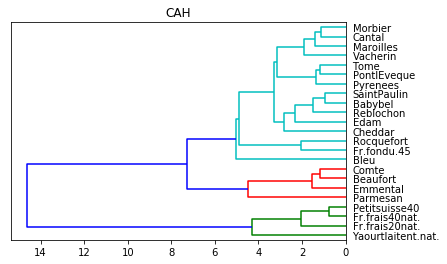

[3 2 3 3 3 2 3 2 3 1 1 3 3 2 1 3 3 3 3 3 3 3 1]


In [23]:
#générer la matrice des liens

Z_subset = linkage(fromage_subset_cr,method='ward',metric='euclidean')

#cah et affichage du dendrogramme

plt.title("CAH")
dendrogram(Z_subset,labels=fromage_subset.index,orientation='left',color_threshold=7)
plt.show()

#groupes

groupes_subset_cah = fcluster(Z_subset,t=7,criterion='distance')
print(groupes_subset_cah)

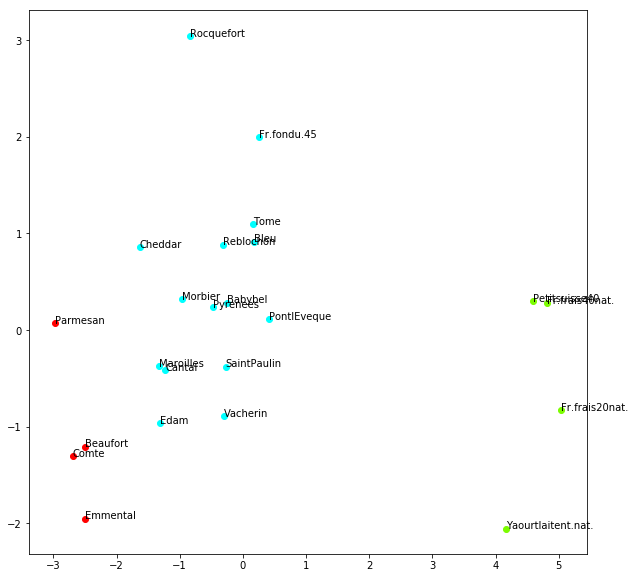

In [24]:
#ACP
acp_subset = PCA(n_components=2).fit_transform(fromage_subset_cr)
#projeter dans le plan factoriel
#avec un code couleur selon le groupe
#remarquer le rôle de zip()
plt.figure(figsize=(10,10))
for couleur,k in zip(['lawngreen','red','aqua'],[1,2,3]):
    plt.scatter(acp_subset[groupes_subset_cah==k,0],acp_subset[groupes_subset_cah==k,1],c=couleur)
#mettre les labels des points
#remarquer le rôle de enumerate()
for i,label in enumerate(fromage_subset.index):
    plt.annotate(label,(acp_subset[i,0],acp_subset[i,1]))
plt.show()

Quelques fromages ont changé de camp...

## Exercice:

Sur le jeu de données suivant: 
    * extraire les données sur les dimensions des pétales
    * effectuer une CAH
    * utilisiser la méthode K-Means
    * Comparer les méthode
    * peut-on dire que la classification est bonne comparée au numéro de l'espèce donné?
    * effectuer une ACP
    * doit-on recommencer en excluant un groupe?


In [25]:
df = pd.read_excel('../data/Iris.xls')   # attention au chemin!!!!!
df

Species_No  Petal_width  Petal_length  Sepal_width  Sepal_length  \
0             1          0.2           1.4          3.5           5.1   
1             1          0.2           1.4          3.0           4.9   
2             1          0.2           1.3          3.2           4.7   
3             1          0.2           1.5          3.1           4.6   
4             1          0.2           1.4          3.6           5.0   
5             1          0.4           1.7          3.9           5.4   
6             1          0.3           1.4          3.4           4.6   
7             1          0.2           1.5          3.4           5.0   
8             1          0.2           1.4          2.9           4.4   
9             1          0.1           1.5          3.1           4.9   
10            1          0.2           1.5          3.7           5.4   
11            1          0.2           1.6          3.4           4.8   
12            1          0.1           1.4          3.0           4.8   
13            1          0.1           1.1          3.0           4.3   
14            1          0.2           1.2          4.0           5.8   
15            1          0.4           1.5          4.4           5.7   
16            1          0.4           1.3          3.9           5.4   
17            1          0.3           1.4          3.5           5.1   
18            1          0.3           1.7          3.8           5.7   
19            1          0.3           1.5          3.8           5.1   
20            1          0.2           1.7          3.4           5.4   
21            1          0.4           1.5          3.7           5.1   
22            1          0.2           1.0          3.6           4.6   
23            1          0.5           1.7          3.3           5.1   
24            1          0.2           1.9          3.4           4.8   
25            1          0.2           1.6          3.0           5.0   
26            1          0.4           1.6          3.4           5.0   
27            1          0.2           1.5          3.5           5.2   
28            1          0.2           1.4          3.4           5.2   
29            1          0.2           1.6          3.2           4.7   
..          ...          ...           ...          ...           ...   
120           3          2.3           5.7          3.2           6.9   
121           3          2.0           4.9          2.8           5.6   
122           3          2.0           6.7          2.8           7.7   
123           3          1.8           4.9          2.7           6.3   
124           3          2.1           5.7          3.3           6.7   
125           3          1.8           6.0          3.2           7.2   
126           3          1.8           4.8          2.8           6.2   
127           3          1.8           4.9          3.0           6.1   
128           3          2.1           5.6          2.8           6.4   
129           3          1.6           5.8          3.0           7.2   
130           3          1.9           6.1          2.8           7.4   
131           3          2.0           6.4          3.8           7.9   
132           3          2.2           5.6          2.8           6.4   
133           3          1.5           5.1          2.8           6.3   
134           3          1.4           5.6          2.6           6.1   
135           3          2.3           6.1          3.0           7.7   
136           3          2.4           5.6          3.4           6.3   
137           3          1.8           5.5          3.1           6.4   
138           3          1.8           4.8          3.0           6.0   
139           3          2.1           5.4          3.1           6.9   
140           3          2.4           5.6          3.1           6.7   
141           3          2.3           5.1          3.1           6.9   
142           3          1.9           5.1          2.7        

In [29]:
petal=df.iloc[:,1:5]
print(petal)

     Petal_width  Petal_length  Sepal_width  Sepal_length
0            0.2           1.4          3.5           5.1
1            0.2           1.4          3.0           4.9
2            0.2           1.3          3.2           4.7
3            0.2           1.5          3.1           4.6
4            0.2           1.4          3.6           5.0
5            0.4           1.7          3.9           5.4
6            0.3           1.4          3.4           4.6
7            0.2           1.5          3.4           5.0
8            0.2           1.4          2.9           4.4
9            0.1           1.5          3.1           4.9
10           0.2           1.5          3.7           5.4
11           0.2           1.6          3.4           4.8
12           0.1           1.4          3.0           4.8
13           0.1           1.1          3.0           4.3
14           0.2           1.2          4.0           5.8
15           0.4           1.5          4.4           5.7
16           0

In [30]:
sd = StandardScaler()
petal_cr = sd.fit_transform(petal.values)

In [ ]:
"""CAH"""

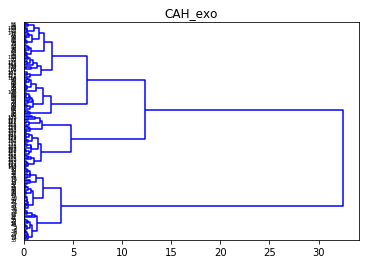

In [32]:
#générer la matrice des liens

lien = linkage(petal,method='ward',metric='euclidean')

#affichage du dendrogramme

plt.title("CAH_exo")
dendrogram(lien,labels=petal.index,orientation='right',color_threshold=0)
plt.show()

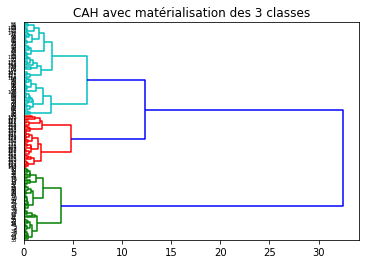

In [34]:
#matérialisation des 3 classes (hauteur t = 10)

plt.title('CAH avec matérialisation des 3 classes')
dendrogram(lien,labels=petal.index,orientation='right',color_threshold=10)
plt.show()


In [36]:
#découpage à la hauteur t = 10 ==> identifiants de 3 groupes obtenus

groupes_cah = fcluster(lien,t=10,criterion='distance')
print(groupes_cah)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 3 2 2 2 2
 2 2 3 3 2 2 2 2 3 2 3 2 3 2 2 3 3 2 2 2 2 2 3 3 2 2 2 3 2 2 2 3 2 2 2 3 2
 2 3]


In [37]:
#index triés des groupes

idg = np.argsort(groupes_cah)

#affichage des observations et leurs groupes

print(pd.DataFrame(petal.index[idg],groupes_cah[idg]))

      0
1     0
1    27
1    28
1    29
1    30
1    31
1    32
1    33
1    34
1    35
1    36
1    26
1    37
1    39
1    40
1    41
1    42
1    43
1    44
1    45
1    46
1    47
1    48
1    38
1    25
1    49
1    23
1    24
1     1
1     3
..  ...
3    52
3    51
3    50
3    71
3    99
3    72
3    75
3    97
3    96
3    95
3    94
3    93
3    92
3    91
3    90
3    89
3    88
3    87
3    86
3    85
3    84
3    83
3    82
3    81
3    80
3    79
3    78
3    76
3    73
3   149

[150 rows x 1 columns]


In [ ]:
"""Kmeans"""

In [38]:
#k-means sur les données centrées et réduites

from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=3)  # on choisit 3 avec l'étude du dessus
kmeans.fit(petal_cr)

#index triés des groupes

print(kmeans.labels_)
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes

print(pd.DataFrame(petal.index[idk],kmeans.labels_[idk]))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0
 0 2 2 2 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]
      0
0    74
0    83
0    82
0    81
0    80
0    79
0    78
0    73
0    72
0    71
0    69
0    84
0    68
0    66
0    64
0    63
0    62
0    61
0    60
0    59
0    58
0    57
0    55
0    67
0    87
0    88
0    89
0   146
0   142
0   138
..  ...
2   140
2   130
2    56
2   116
2   120
2    85
2    86
2    77
2    76
2    75
2   148
2    70
2   100
2    52
2   102
2   103
2   104
2   105
2    65
2   107
2   108
2   109
2   110
2   111
2   112
2   115
2   117
2   118
2   122
2    51

[150 rows x 1 columns]


In [39]:
#distances aux centres de classes des observations

dist_data = pd.DataFrame(kmeans.transform(petal_cr),index = petal.index)
print(dist_data)

            0         1         2
0    3.121198  0.212958  3.989406
1    2.675508  0.996045  4.017933
2    2.974167  0.651984  4.193437
3    2.880144  0.903456  4.197847
4    3.300226  0.402155  4.111572
5    3.505544  1.211548  3.898931
6    3.148564  0.502449  4.216380
7    2.991848  0.091325  3.973134
8    2.925159  1.421747  4.407572
9    2.793990  0.789931  4.057643
10   3.321253  0.789994  3.920881
11   3.049363  0.276181  4.078536
12   2.806350  1.034979  4.164404
13   3.212210  1.334825  4.630697
14   3.888350  1.638656  4.146193
15   4.499830  2.398988  4.495475
16   3.609780  1.207488  4.029661
17   3.055942  0.216188  3.913885
18   3.344940  1.209867  3.725620
19   3.500654  0.867062  4.101019
20   2.808257  0.504016  3.663837
21   3.278008  0.668264  3.944967
22   3.589909  0.686581  4.510613
23   2.559347  0.479456  3.579964
24   2.964932  0.363454  3.988174
25   2.556827  0.990239  3.884319
26   2.827972  0.226831  3.790888
27   3.059708  0.294719  3.895399
28   2.954253 

In [40]:
#correspondance avec les groupes de la CAH

pd.crosstab(groupes_cah,kmeans.labels_)

col_0   0   1   2
row_0            
1       0  50   0
2       0   0  36
3      53   0  11

[0.58175005 0.45937792 0.38385092 0.34741382 0.33992273 0.34086959
 0.33888941 0.35613281 0.35139338]


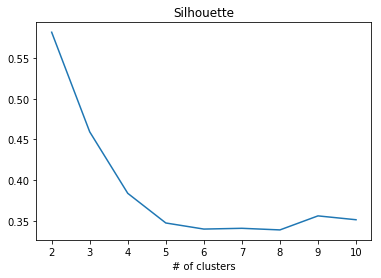

In [41]:
#librairie pour évaluation des partitions
from sklearn import metrics

#utilisation de la métrique "silhouette"
#faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(petal_cr)
    res[k] = metrics.silhouette_score(petal_cr,km.labels_)
print(res)

#graphique
import matplotlib.pyplot as plt
plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

[251.34933946 241.9044017  207.26660627 203.26741933 187.10107374
 178.28855445 172.66938315 177.5795058  178.88777381]


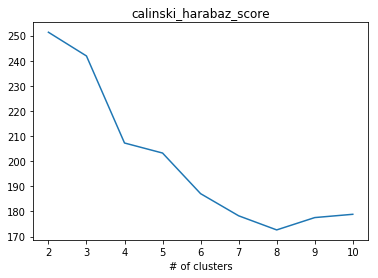

In [42]:
#utilisation de la métrique "calinski_harabaz_score"
#faire varier le nombre de clusters de 2 à 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
    km = cluster.KMeans(n_clusters=k+2)
    km.fit(petal_cr)
    res[k] = metrics.calinski_harabaz_score(petal_cr,km.labels_)
print(res)

#graphique
import matplotlib.pyplot as plt
plt.title("calinski_harabaz_score")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [43]:
#moyenne par variable

m = petal.mean()

#TSS

TSS = petal.shape[0]*petal.var(ddof=0)
print(TSS)

Petal_width      86.569933
Petal_length    464.325400
Sepal_width      28.306933
Sepal_length    102.168333
dtype: float64


In [44]:
#data.frame conditionnellement aux groupes

gb = petal.groupby(kmeans.labels_)

#effectifs conditionnels

nk = gb.size()
print(nk)

0    53
1    50
2    47
dtype: int64


In [45]:
#moyennes conditionnelles

mk = gb.mean()
print(mk)

#pour chaque groupe écart à la moyenne par variable

EMk = (mk-m)**2

#pondéré par les effectifs du groupe

EM = EMk.multiply(nk,axis=0)


   Petal_width  Petal_length  Sepal_width  Sepal_length
0     1.413208      4.369811     2.673585      5.801887
1     0.246000      1.462000     3.428000      5.006000
2     1.972340      5.510638     3.095745      6.780851


In [46]:
#somme des valeurs => BSS

BSS = np.sum(EM,axis=0)
print(BSS)

Petal_width      75.950936
Petal_length    427.791221
Sepal_width      14.743966
Sepal_length     76.457556
dtype: float64


In [47]:
#carré du rapport de corrélation
#variance expliquée par l'appartenance aux groupes pour chaque variable

R2 = BSS/TSS
print(R2)

Petal_width     0.877336
Petal_length    0.921318
Sepal_width     0.520861
Sepal_length    0.748349
dtype: float64


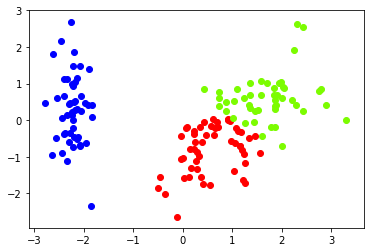

In [49]:
#ACP

from sklearn.decomposition import PCA
acp = PCA(n_components=2).fit_transform(petal_cr)

#projeter dans le plan factoriel avec un code couleur différent selon le groupe

for couleur,k in zip(['red','blue','lawngreen','aqua'],[0,1,2,3]):
    plt.scatter(acp[kmeans.labels_==k,0],acp[kmeans.labels_==k,1],c=couleur)
plt.show()

In [50]:
#retirer des observations le groupe n°1 du k-means précédent
petal_subset = petal.iloc[kmeans.labels_!=0,:]

print(petal_subset.shape)
print(petal_subset)

(97, 4)
     Petal_width  Petal_length  Sepal_width  Sepal_length
0            0.2           1.4          3.5           5.1
1            0.2           1.4          3.0           4.9
2            0.2           1.3          3.2           4.7
3            0.2           1.5          3.1           4.6
4            0.2           1.4          3.6           5.0
5            0.4           1.7          3.9           5.4
6            0.3           1.4          3.4           4.6
7            0.2           1.5          3.4           5.0
8            0.2           1.4          2.9           4.4
9            0.1           1.5          3.1           4.9
10           0.2           1.5          3.7           5.4
11           0.2           1.6          3.4           4.8
12           0.1           1.4          3.0           4.8
13           0.1           1.1          3.0           4.3
14           0.2           1.2          4.0           5.8
15           0.4           1.5          4.4           5.7
16    

In [51]:
#centrer et réduire
petal_subset_cr = sc.fit_transform(petal_subset.values)
print(petal_subset_cr)

[[-0.98549257 -0.9756683   0.63952646 -0.7802771 ]
 [-0.98549257 -0.9756683  -0.73290864 -0.98401029]
 [-0.98549257 -1.02388013 -0.1839346  -1.18774348]
 [-0.98549257 -0.92745647 -0.45842162 -1.28961007]
 [-0.98549257 -0.9756683   0.91401348 -0.8821437 ]
 [-0.76214495 -0.8310328   1.73747454 -0.47467732]
 [-0.87381876 -0.9756683   0.36503944 -1.28961007]
 [-0.98549257 -0.92745647  0.36503944 -0.8821437 ]
 [-0.98549257 -0.9756683  -1.00739566 -1.49334326]
 [-1.09716637 -0.92745647 -0.45842162 -0.98401029]
 [-0.98549257 -0.92745647  1.1885005  -0.47467732]
 [-0.98549257 -0.87924463  0.36503944 -1.08587688]
 [-1.09716637 -0.9756683  -0.73290864 -1.08587688]
 [-1.09716637 -1.12030379 -0.73290864 -1.59520985]
 [-0.98549257 -1.07209196  2.01196156 -0.06721095]
 [-0.76214495 -0.92745647  3.10990963 -0.16907754]
 [-0.76214495 -1.02388013  1.73747454 -0.47467732]
 [-0.87381876 -0.9756683   0.63952646 -0.7802771 ]
 [-0.87381876 -0.8310328   1.46298752 -0.16907754]
 [-0.87381876 -0.92745647  1.46

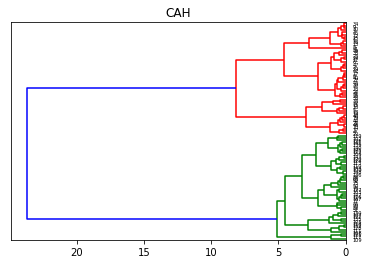

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [52]:
#générer la matrice des liens

lien_subset = linkage(petal_subset_cr,method='ward',metric='euclidean')

#cah et affichage du dendrogramme

plt.title("CAH")
dendrogram(lien_subset,labels=petal_subset.index,orientation='left',color_threshold=11)
plt.show()

#groupes

groupes_subset_cah = fcluster(lien_subset,t=11,criterion='distance')
print(groupes_subset_cah)

In [53]:
#index triés des groupes

idg = np.argsort(groupes_subset_cah)

#affichage des observations et leurs groupes

print(pd.DataFrame(petal.index[idg],groupes_subset_cah[idg]))

     0
1   96
1   69
1   68
1   67
1   66
1   65
1   64
1   63
1   62
1   61
1   70
1   60
1   58
1   57
1   56
1   55
1   54
1   53
1   52
1   51
1   50
1   59
1   71
1   72
1   73
1   94
1   93
1   92
1   91
1   90
..  ..
2    3
2    2
2    1
2   10
2   22
2   23
2   24
2   45
2   44
2   43
2   42
2   41
2   40
2   39
2   38
2   37
2   36
2   35
2   34
2   33
2   32
2   31
2   30
2   29
2   28
2   27
2   26
2   25
2   47
2   48

[97 rows x 1 columns]


In [54]:
#k-means sur les données centrées et réduites

from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=2)  # on choisit 2 avec l'étude du dessus
kmeans.fit(petal_subset_cr)

#index triés des groupes

print(kmeans.labels_)
idk = np.argsort(kmeans.labels_)

#affichage des observations et leurs groupes

print(pd.DataFrame(petal.index[idk],kmeans.labels_[idk]))


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
     0
0   96
0   69
0   68
0   67
0   66
0   65
0   64
0   63
0   62
0   61
0   70
0   60
0   58
0   57
0   56
0   55
0   54
0   53
0   52
0   51
0   50
0   59
0   71
0   72
0   73
0   94
0   93
0   92
0   91
0   90
..  ..
1    3
1    2
1    1
1   10
1   22
1   23
1   24
1   45
1   44
1   43
1   42
1   41
1   40
1   39
1   38
1   37
1   36
1   35
1   34
1   33
1   32
1   31
1   30
1   29
1   28
1   27
1   26
1   25
1   47
1   48

[97 rows x 1 columns]


In [55]:
#correspondance avec les groupes de la CAH

pd.crosstab(groupes_subset_cah,kmeans.labels_)

col_0   0   1
row_0        
1      47   0
2       0  50

In [56]:
#data.frame conditionnellement aux groupes

gb = petal_subset.groupby(kmeans.labels_)

#effectifs conditionnels

nk = gb.size()
print(nk)

0    47
1    50
dtype: int64


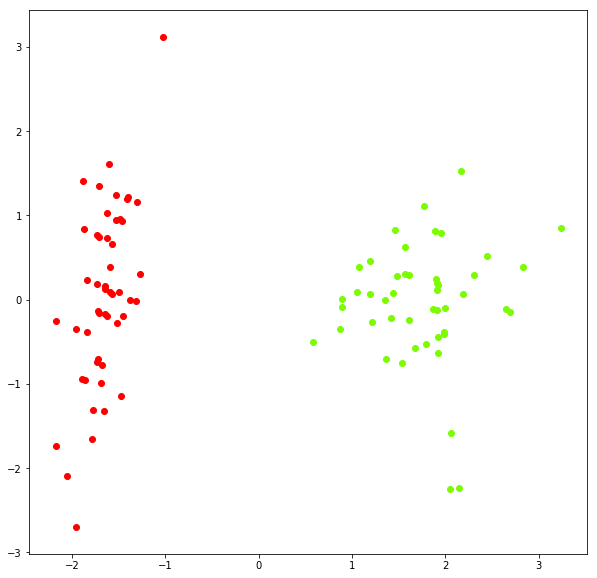

In [57]:
#ACP
acp_subset = PCA(n_components=2).fit_transform(petal_subset_cr)
#projeter dans le plan factoriel
#avec un code couleur selon le groupe
#remarquer le rôle de zip()
plt.figure(figsize=(10,10))
for couleur,k in zip(['lawngreen','red','aqua'],[1,2,3]):
    plt.scatter(acp_subset[groupes_subset_cah==k,0],acp_subset[groupes_subset_cah==k,1],c=couleur)
#mettre les labels des points
#remarquer le rôle de enumerate()
#for i,label in enumerate(x_subset.index):
    #plt.annotate(label,(acp_subset[i,0],acp_subset[i,1]))
plt.show()